# IMDB Sentiment Analysis with TextCNN (PyTorch & TorchText)


#### This notebook demonstrates a complete deep learning workflow for sentiment analysis on the IMDB movie reviews dataset using a custom TextCNN model implemented in PyTorch. It covers data loading, cleaning, tokenization, vocabulary building, encoding, and efficient batching with TorchText. The notebook includes model definition, training with validation, learning rate scheduling, and evaluation with metrics and confusion matrix visualization. Misclassified examples are analyzed to help understand model limitations and guide further improvements.

## Check device CPU/GPU

In [ ]:
# Check if CUDA GPU is available on the set device
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Install required packages

In [ ]:
# Install PyTorch and TorchText
!pip install -U torch==2.3.1+cu121 torchtext==0.18.0 -f https://download.pytorch.org/whl/torch_stable.html


Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.9/780.9 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 129.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 105.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/

## Fix Torchmetrics Installation 

In [ ]:
# Uninstall broken torchmetrics and install compatible version
!pip uninstall -y torchmetrics
!pip install -U --no-cache-dir torchmetrics==1.4.0

Found existing installation: torchmetrics 1.4.0
Uninstalling torchmetrics-1.4.0:
  Successfully uninstalled torchmetrics-1.4.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 38.8 MB/s eta 0:00:00


## Import Libraries 

In [ ]:
# Import all required libraries for data processing, modeling, and evaluation
from datasets import load_dataset
import time
import copy
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import GradScaler, autocast
from torchmetrics.classification import MulticlassAccuracy, BinaryF1Score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

/usr/local/lib/python3.12/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.12/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.12/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

## Load Dataset

In [ ]:
# Load the IMDB Sentiment dataset and convert to pandas DataFrames
ds = load_dataset("Kwaai/IMDB_Sentiment")

df_train = ds["train"].to_pandas()[["text","label"]]
df_test = ds["test"].to_pandas()[["text","label"]]

print("Train shape:", df_train.shape, "| Test shape:", df_test.shape)
df_train.head()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Train shape: (25000, 2) | Test shape: (25000, 2)


,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


## Clean data nd build vocabulary 

In [ ]:
# Clean text and build vocabulary from training data
def clean(text):
  text = re.sub(r"<br\s*/?>", " ", str(text))
  text = re.sub(r"\s+", " ", text).strip()
  return text.lower()

# Tokenizer
tokenizer = get_tokenizer("basic_english")

def yield_tokens_from_train(df):
  for t in df['text'].tolist():
    yield tokenizer(clean(t))

# Build vocab from train only to avoid leakage
MAX_VOCCAB = 60000
vocab = build_vocab_from_iterator(
    yield_tokens_from_train(df_train),
    max_tokens=MAX_VOCCAB,
    specials=["<pad>","<unk>"]
)
vocab.set_default_index(vocab["<unk>"])

PAD_IDX = vocab["<pad>"]
UNK_IDX = vocab["<unk>"]

print("Vocab size:", len(vocab), "| PAD_IDX:", PAD_IDX, "| UNK_IDX:", UNK_IDX)

lengths = [len(tokenizer(clean(t))) for t in df_train["text"].tolist()]
p95 = int(np.percentile(lengths, 95))
print("P95:", p95)



Vocab size: 60000 | PAD_IDX: 0 | UNK_IDX: 1
P95: 692


## Encode and truncate reviews

In [ ]:
# Encode reviews as token IDs and truncate/pad to fixed length

MAX_LEN = 500
LEFT = MAX_LEN//2
RIGHT = MAX_LEN - LEFT

def head_tail_truncate(ids, max_len=MAX_LEN):
  if len(ids) > max_len:
    return ids[:LEFT] + ids[-RIGHT:]
  else:
    return ids

def encode_ids(text):
  toks = tokenizer(clean(text))
  ids = [vocab[t] for t in toks]
  ids = head_tail_truncate(ids, MAX_LEN)
  if len(ids)<MAX_LEN:
    ids += [PAD_IDX]*(MAX_LEN-len(ids))
  return torch.tensor(ids, dtype=torch.long)


## Prepare datasets and data loaders 

In [ ]:
# Split into train and validation and build PyTorch DataLoaders

class SentimentAnalysisDataset(Dataset):
  def __init__(self, df):
    self.textx = df["text"].tolist()
    self.labels = df["label"].astype(int).tolist()
  def __len__(self):
    return len(self.labels)
  def __getitem__(self, idx):
    x_ids = encode_ids(self.textx[idx])
    y = torch.tensor(self.labels[idx], dtype=torch.long)
    return x_ids, y

def collect_batch(batch):
  ids = torch.stack([x[0] for x in batch], dim=0) # (B,L)
  ys = torch.stack([x[1] for x in batch], dim=0) # (B,)
  return ids, ys

# make validation split
train_df, val_df = train_test_split(
    df_train,
    test_size=0.2,
    stratify=df_train["label"],
    random_state=42
    )

train_ds = SentimentAnalysisDataset(train_df)
val_ds = SentimentAnalysisDataset(val_df)
test_ds = SentimentAnalysisDataset(df_test)

# DataLoaders

BATCH_SIZE = 256

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=2, pin_memory=True, collate_fn=collect_batch)

val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=2, pin_memory=True, collate_fn=collect_batch)

test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=2, pin_memory=True, collate_fn=collect_batch)


## Model Definition : TextCNN 

In [ ]:
# Define TextCNN model with residual convolutional blocks

class ResidualConvBlock(nn.Module):
  """Conv-BN-ReLU -> Conv-BN + residual (keeps time length with padding)"""
  def __init__(self, channels, kernel_size, p_drop=0.1):
    super().__init__()
    pad = kernel_size//2
    self.conv1 = nn.Conv1d(channels, channels, kernel_size, padding=pad)
    self.bn1 = nn.BatchNorm1d(channels)
    self.conv2 = nn.Conv1d(channels, channels, kernel_size, padding=pad)
    self.bn2 = nn.BatchNorm1d(channels)
    self.drop = nn.Dropout(p_drop)

  def forward(self, x):
    out = self.drop(F.relu(self.bn1(self.conv1(x))))
    out = self.bn2(self.conv2(out))
    out = F.relu(out + x) # residual
    return out

class TextCNN(nn.Module):
  def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,
               depth=2, pad_idx=0, dropout=0.5):
    super().__init__()

    assert len(kernel_sizes) == len(num_channels)

    self.embed_train = nn.Embedding(vocab_size, embed_size, padding_idx=pad_idx)
    self.embed_static = nn.Embedding(vocab_size, embed_size, padding_idx=pad_idx)
    self.embed_static.weight.requires_grad = False # freeze static channel

    in_ch = 2*embed_size # trainanle + static concatenated along features

    # Build a conv "branch" per kernel size
    branches = []
    pools_max, pools_avg = [], []
    for k, c in zip(kernel_sizes, num_channels):
      pad = k//2
      stem = nn.Sequential(
          nn.Conv1d(in_channels=in_ch, out_channels=c, kernel_size=k, padding=pad),
          nn.BatchNorm1d(c),
          nn.ReLU(inplace=True)
      )
      # residual stack
      res_stack = nn.Sequential(*[ResidualConvBlock(c, k, p_drop=0.1) for _ in range(max(0,depth))])

      branch = nn.Sequential(stem, res_stack)
      branches.append(branch)

      pools_max.append(nn.AdaptiveMaxPool1d(1))
      pools_avg.append(nn.AdaptiveAvgPool1d(1))

    self.branches = nn.ModuleList(branches)
    self.pools_max = nn.ModuleList(pools_max)
    self.pools_avg = nn.ModuleList(pools_avg)

    feat_dim = 2*sum(num_channels) # max+avg per branch
    self.dropout = nn.Dropout(dropout)
    self.decoder = nn.Linear(feat_dim, 2)

    # init & ensure PAD rows are zeroed
    self._reset_parameters()
    with torch.no_grad():
      self.embed_train.weight.data[pad_idx].zero_()
      self.embed_static.weight.data[pad_idx].zero_()


  def _reset_parameters(self):
    for m in self.modules():
      if isinstance(m, nn.Conv1d):
        nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")
        if m.bias is not None:
          nn.init.zeros_(m.bias)
      elif isinstance(m, nn.BatchNorm1d):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)
      elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
          nn.init.zeros_(m.bias)

  def forward(self, inputs, lengths = None):
    """
    inputs: LongTensor (B,L) with PAD at pad_idx
    returns: probabilities (B,) in [0,1]
    """

    # embeddings: (B, L, E) each -> concat on last dim -> (B, L, 2E)
    emb_t = self.embed_train(inputs)
    emb_s = self.embed_static(inputs)
    emb = torch.cat((emb_t, emb_s), dim=2)

    x = emb.permute(0, 2, 1)

    feats = []
    for branch, pool_max, pool_avg in zip(self.branches, self.pools_max, self.pools_avg):
      h = branch(x)
      h_max = pool_max(h).squeeze(-1)
      h_avg = pool_avg(h).squeeze(-1)
      feats.append(torch.cat((h_max, h_avg), dim=1))

    z = torch.cat(feats, dim=1)
    z = self.dropout(z)
    logits = self.decoder(z)
    return logits, None

## Training and Validation Loop 

In [ ]:
# Training and validation loop for TextCNN model
# Includes early stopping and learning rate scheduling
# Tracks accuracy and F1 score for each epoch
# Saves best model checkpoint
# Returns training history

def train_val_loop(
    model,
    train_loader,
    val_loader,
    device,
    ckpt_path,
    num_epochs=30,
    lr=1e-3,
    weight_decay=0.01,
    clip_norm=1.0
):
    model.to(device)
    loss_fn = nn.CrossEntropyLoss(label_smoothing=0.05)
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.2, patience=3,
                                  cooldown=1, min_lr=1e-5, verbose=True)
    scaler = GradScaler(enabled=(device.type == "cuda"))

    # Metrics (train & val)
    tr_acc = MulticlassAccuracy(num_classes=2).to(device)
    tr_f1  = BinaryF1Score().to(device)
    va_acc = MulticlassAccuracy(num_classes=2).to(device)
    va_f1  = BinaryF1Score().to(device)

    best_state = None
    best_val_f1 = -1.0

    # Histories
    hist = {
        "train_loss": [], "train_acc": [], "train_f1": [],
        "val_loss": [],   "val_acc": [],   "val_f1": []
    }

    start = time.perf_counter()

    for ep in range(1, num_epochs + 1):
        # ----- TRAIN -----
        model.train()
        tr_acc.reset(); tr_f1.reset()
        total_loss, total_count = 0.0, 0

        for ids, ys in train_loader:
            ids, ys = ids.to(device), ys.to(device)
            optimizer.zero_grad(set_to_none=True)

            with autocast(enabled=(device.type == "cuda")):
                logits, _ = model(ids, None)        # (B, 2)
                loss = loss_fn(logits, ys)

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
            scaler.step(optimizer)
            scaler.update()

            bs = ys.size(0)
            total_loss  += loss.item() * bs
            total_count += bs

            preds = torch.argmax(logits, dim=1)               # 0/1
            probs_pos = torch.softmax(logits, dim=1)[:, 1]    # P(class=1)
            tr_acc.update(preds, ys)
            tr_f1.update(probs_pos, ys)

        train_loss = total_loss / max(1, total_count)
        train_acc  = tr_acc.compute().item()
        train_f1   = tr_f1.compute().item()

        # ----- VALIDATE -----
        model.eval()
        va_acc.reset(); va_f1.reset()
        val_loss_sum, val_count = 0.0, 0

        with torch.no_grad():
            for ids, ys in val_loader:
                ids, ys = ids.to(device), ys.to(device)
                logits, _ = model(ids, None)
                vloss = loss_fn(logits, ys)

                bs = ys.size(0)
                val_loss_sum += vloss.item() * bs
                val_count    += bs

                preds = torch.argmax(logits, dim=1)
                probs_pos = torch.softmax(logits, dim=1)[:, 1]
                va_acc.update(preds, ys)
                va_f1.update(probs_pos, ys)

        val_loss = val_loss_sum / max(1, val_count)
        val_acc  = va_acc.compute().item()
        val_f1   = va_f1.compute().item()

        # Log
        print(f"Epoch {ep:02d} | "
              f"train: loss {train_loss:.4f}, acc {train_acc*100:.2f}%, f1 {train_f1:.4f} | "
              f"val: loss {val_loss:.4f}, acc {val_acc*100:.2f}%, f1 {val_f1:.4f} | "
              f"lr {optimizer.param_groups[0]['lr']:.2e}")

        # Scheduler on validation loss
        scheduler.step(val_loss)

        # saving model with best accuracy
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_state = copy.deepcopy(model.state_dict())
            if ckpt_path:
                torch.save(best_state, ckpt_path)
                print(f"  ↳ Saved best to {ckpt_path} (val f1 {best_val_f1:.4f})")

        # Save histories
        hist["train_loss"].append(train_loss)
        hist["train_acc"].append(train_acc)
        hist["train_f1"].append(train_f1)
        hist["val_loss"].append(val_loss)
        hist["val_acc"].append(val_acc)
        hist["val_f1"].append(val_f1)

    elapsed = (time.perf_counter() - start) / 60.0
    print(f"Done in {elapsed:.2f} min.")

    return hist


## Testing and Error Analysis 

In [ ]:
import itertools
# Test loop: loads best model, evaluates on test set, plots confusion matrix
# Prints targeted misclassified examples (false positives and false negatives)
def test_loop(model_ctor, ckpt_path, test_loader, device,
              num_classes=2, plot_confusion=True, normalize_cm=True, class_names=None, id2word=None):

    # --- build model and load weights ---
    model = model_ctor().to(device)
    state = torch.load(ckpt_path, map_location=device)
    state_dict = state.get("model_state", state) if isinstance(state, dict) else state
    model.load_state_dict(state_dict)
    model.eval()

    # --- run inference ---
    all_preds, all_labels, all_inputs = [], [], []
    with torch.no_grad():
        for ids, ys in test_loader:
            ids, ys = ids.to(device), ys.to(device)
            logits, _ = model(ids, None)
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(ys.cpu().numpy())
            all_inputs.extend(ids.cpu().numpy())


    # --- metrics (macro) ---
    acc = accuracy_score(all_labels, all_preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="macro", zero_division=0
    )
    print(f"Test Accuracy: {acc*100:.2f}% | Precision: {prec*100:.2f}% | "
          f"Recall: {rec*100:.2f}% | F1: {f1*100:.2f}%")

    # --- confusion matrix ---
    if plot_confusion:
        labels = list(range(num_classes))
        cm = confusion_matrix(all_labels, all_preds, labels=labels,
                              normalize="true" if normalize_cm else None)
        if normalize_cm:
            cm = cm * 100.0  # to %
        plt.figure(figsize=(8, 6))
        plt.imshow(cm, interpolation="nearest")
        title = "Confusion Matrix (% by true class)" if normalize_cm else "Confusion Matrix (counts)"
        plt.title(title)
        plt.xlabel("Predicted"); plt.ylabel("True")
        cbar_label = "% within true class" if normalize_cm else "count"
        plt.colorbar(label=cbar_label)
        ticks = np.arange(num_classes)
        tick_labels = class_names if (class_names and len(class_names)==num_classes) else ticks
        plt.xticks(ticks, tick_labels, rotation=45, ha="right"); plt.yticks(ticks, tick_labels)

        # annotate cells
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            val = cm[i, j]
            show = (val >= 1.0) if normalize_cm else (val > 0)
            if show:
                txt = f"{val:.0f}%" if normalize_cm else str(int(val))
                plt.text(j, i, txt, ha="center", va="center",
                         color="white" if val > (50 if normalize_cm else cm.max()/2) else "black",
                         fontsize=9)
        plt.tight_layout()
        plt.savefig("confusion_matrix.png", dpi=150)
        plt.show()

         # --- show targeted misclassified examples ---
        print("\n--- Misclassified: Negative → Positive (False Positives) ---")
        count = 0
        for x, y, p in zip(all_inputs, all_labels, all_preds):
            if y == 0 and p == 1:  # true Neg, predicted Pos
                if id2word:
                    tokens = [id2word.get(i, "<unk>") for i in x if i not in [0,1,2]]
                    text = " ".join(tokens)
                else:
                    text = str(x)
                print(f"True: {class_names[y] if class_names else y} | "
                      f"Pred: {class_names[p] if class_names else p} | Input: {text}")
                count += 1
                if count >= 10:
                    break

        print("\n--- Misclassified: Positive → Negative (False Negatives) ---")
        count = 0
        for x, y, p in zip(all_inputs, all_labels, all_preds):
            if y == 1 and p == 0:  # true Pos, predicted Neg
                if id2word:
                    tokens = [id2word.get(i, "<unk>") for i in x if i not in [0,1,2]]
                    text = " ".join(tokens)
                else:
                    text = str(x)
                print(f"True: {class_names[y] if class_names else y} | "
                      f"Pred: {class_names[p] if class_names else p} | Input: {text}")
                count += 1
                if count >= 10:
                    break


## Glove Embedding Initialisation 

[GloVe] matched 48491/60000 tokens
Model params: 13.37M
Epoch 01 | train: loss 2.2282, acc 59.01%, f1 0.5939 | val: loss 0.9158, acc 70.86%, f1 0.7662 | lr 5.00e-04
  ↳ Saved best to Text_cnn.pth (val f1 0.7662)
Epoch 02 | train: loss 0.8503, acc 73.70%, f1 0.7366 | val: loss 0.5013, acc 82.34%, f1 0.8424 | lr 5.00e-04
  ↳ Saved best to Text_cnn.pth (val f1 0.8424)
Epoch 03 | train: loss 0.5619, acc 79.67%, f1 0.7970 | val: loss 0.3910, acc 86.12%, f1 0.8683 | lr 5.00e-04
  ↳ Saved best to Text_cnn.pth (val f1 0.8683)
Epoch 04 | train: loss 0.4461, acc 83.57%, f1 0.8362 | val: loss 0.3531, acc 87.34%, f1 0.8761 | lr 5.00e-04
  ↳ Saved best to Text_cnn.pth (val f1 0.8761)
Epoch 05 | train: loss 0.3807, acc 86.84%, f1 0.8678 | val: loss 0.5179, acc 79.00%, f1 0.8246 | lr 5.00e-04
Epoch 06 | train: loss 0.3267, acc 89.81%, f1 0.8984 | val: loss 0.6641, acc 72.40%, f1 0.7830 | lr 5.00e-04
Epoch 07 | train: loss 0.2811, acc 91.98%, f1 0.9201 | val: loss 0.5174, acc 80.70%, f1 0.8364 | lr 5.

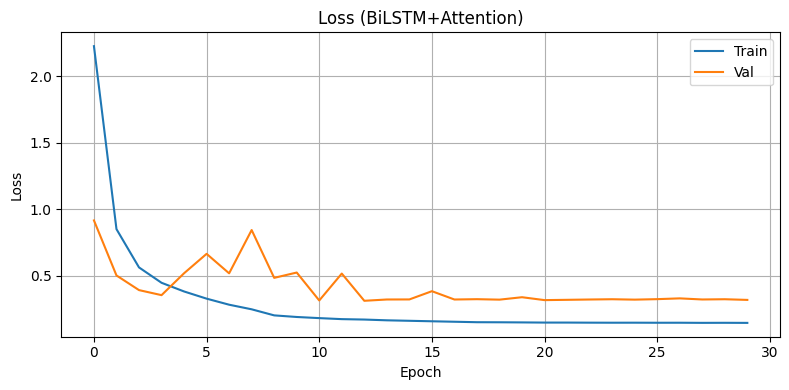

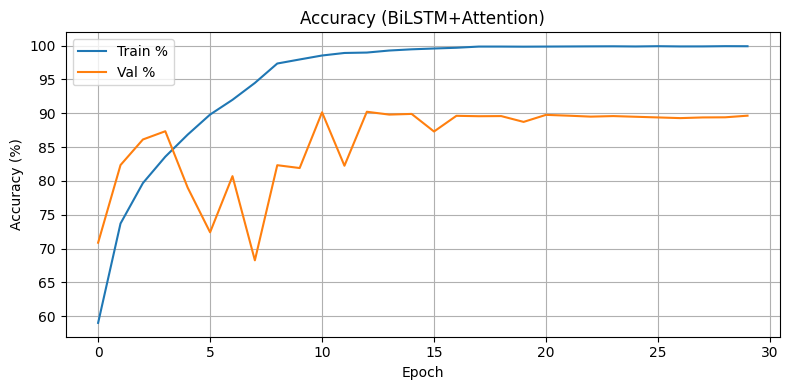

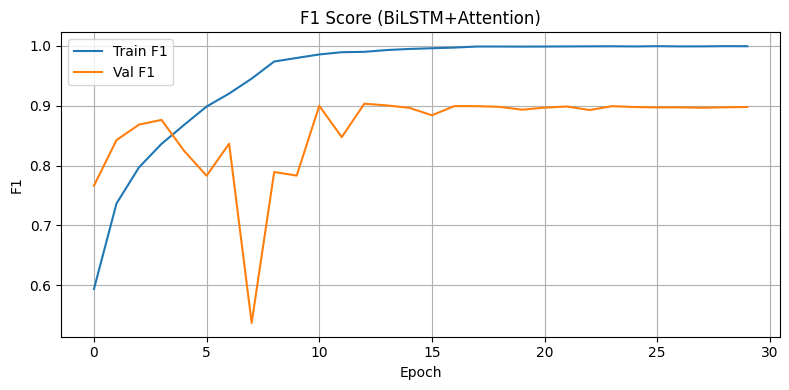

Test Accuracy: 89.30% | Precision: 89.31% | Recall: 89.30% | F1: 89.30%


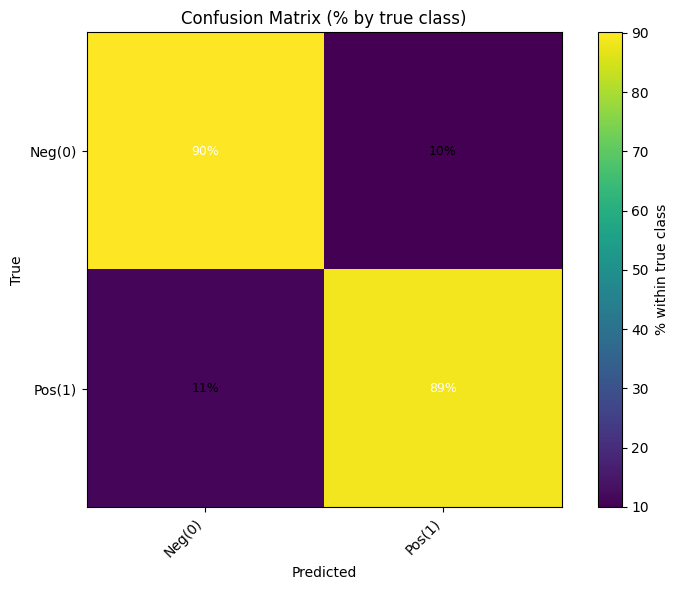


--- Misclassified: Negative → Positive (False Positives) ---
True: Neg(0) | Pred: Pos(1) | Input: first off let me say , if you haven ' t enjoyed a van damme movie since bloodsport , you probably will not like this movie . most of these movies may not have best plots or best actors but i enjoy these kinds of movies for what they are . this movie is much better than any of movies other action guys ( segal and dolph ) have thought about putting out past few years . van damme is good in movie , movie is only worth watching to van damme fans . it is not as good as wake of death ( which i highly recommend to anyone of likes van damme ) or in hell but , in my opinion it ' s worth watching . it has same type of feel to it as nowhere to run . good fun stuff !
True: Neg(0) | Pred: Pos(1) | Input: blind date ( columbia pictures , 1934 ) , was a decent film , but i have a few issues with this film . first of all , i don ' t fault actors in this film at all , but more or less , i have a problem w

In [ ]:

# Build GloVe embedding matrix for vocabulary

NUM_CLASSES = 2
textcnn_ckpt = "Text_cnn.pth"

EMBED_DIM = 100

def build_glove_matrix(vocab, embed_dim, pad_idx=None, unk_idx=None):
    V = len(vocab)
    emb = torch.empty(V, embed_dim)
    torch.nn.init.normal_(emb, mean=0.0, std=0.05)  # random init for OOVs

    try:
        from torchtext.vocab import GloVe
        glove = GloVe(name="6B", dim=embed_dim)
        itos = vocab.get_itos() if hasattr(vocab, "get_itos") else [vocab.lookup_token(i) for i in range(V)]
        vecs = glove.get_vecs_by_tokens(itos, lower_case_backup=True)  # (V, D); OOV -> zeros
        mask = (vecs.abs().sum(dim=1) > 0)
        emb[mask] = vecs[mask]
        print(f"[GloVe] matched {int(mask.sum().item())}/{V} tokens")
    except Exception as e:
        print(f"[GloVe] load failed: {e}. Using random init for all tokens.")

    if pad_idx is not None and 0 <= pad_idx < V:
        emb[pad_idx].zero_()
    return emb

glove_mat = build_glove_matrix(vocab, EMBED_DIM, PAD_IDX, UNK_IDX)


# instantiate
def make_textcnn():
    m = TextCNN(
        vocab_size=len(vocab),
        embed_size=100,                 # 100–300 also fine
        kernel_sizes=(3, 5, 7),
        num_channels=(128, 128, 128),
        depth=2,
        pad_idx=PAD_IDX,
        dropout=0.5
    )
    with torch.no_grad():
        m.embed_train.weight[:]  = glove_mat
        m.embed_static.weight[:] = glove_mat
        m.embed_train.weight[PAD_IDX].zero_()
        m.embed_static.weight[PAD_IDX].zero_()
        m.embed_static.weight.requires_grad = False
        m.embed_train.weight.requires_grad  = True
    return m

# Instantiate TextCNN, initialize embeddings, train, plot metrics, and test

textcnn_model = make_textcnn()
param_count = sum(p.numel() for p in textcnn_model.parameters())
print(f"Model params: {param_count/1e6:.2f}M")

hist = train_val_loop(
    model=textcnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    ckpt_path=textcnn_ckpt,
    num_epochs=30,
    lr=5e-4,
    weight_decay=0.01,
    clip_norm=1.0
)

# Best epoch by lowest val loss
best_epoch = 1 + int(np.argmin(hist["val_loss"]))
print(f"Best epoch: {best_epoch} (val loss = {min(hist['val_loss']):.4f})")

# ---- Plot curves ----
plt.figure(figsize=(8,4))
plt.plot(hist["train_loss"], label="Train")
plt.plot(hist["val_loss"],   label="Val")
plt.title("Loss (BiLSTM+Attention)")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4))
plt.plot([a*100 for a in hist["train_acc"]], label="Train %")
plt.plot([a*100 for a in hist["val_acc"]],   label="Val %")
plt.title("Accuracy (BiLSTM+Attention)")
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4))
plt.plot(hist["train_f1"], label="Train F1")
plt.plot(hist["val_f1"],   label="Val F1")
plt.title("F1 Score (BiLSTM+Attention)")
plt.xlabel("Epoch"); plt.ylabel("F1")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

try:
    id2word = {i: tok for i, tok in enumerate(vocab.get_itos())}
except Exception:
    id2word = None

# ---- Test ----
test_loop(
    model_ctor=make_textcnn,
    ckpt_path=textcnn_ckpt,
    test_loader=test_loader,
    device=device,
    num_classes=NUM_CLASSES,
    plot_confusion=True,
    normalize_cm=True,
    class_names=["Neg(0)", "Pos(1)"],
    id2word=id2word
)